# Setup Environment

In [1]:
%load_ext autoreload
import os
import sys
import requests
import pandas as pd
import janitor
import datamapplot

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
path_to_add = os.path.join(parent_dir, "src")
sys.path.insert(0, path_to_add)

Matplotlib is building the font cache; this may take a moment.
c:\Users\LONAL23\OneDrive - PA Consulting Group\7 - Data Scientist\pandas-survey-toolkit\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get Data

## Free text comments

url = "https://data.austintexas.gov/resource/jeyv-db9u.json"

## Likert data
url_likert = "https://data.austintexas.gov/resource/s2py-ceb7.json"
data_dictionary_url = "https://data.austintexas.gov/api/views/s2py-ceb7/columns.json"

url = "https://data.austintexas.gov/dataset/Community-Survey/s2py-ceb7/about_data"

We have saved these data as CSV files in the repo



## Questions data (likert)

In [19]:
dfl = pd.read_csv("../data/Community_Survey_20240911.csv").clean_names()

C:\Users\LONAL23\AppData\Local\Temp\ipykernel_1224\2967390319.py:1: DtypeWarning: Columns (7,9,10,12,13,14,15,16,17,18,19,20,21,25,30,31,32,36,37,38,39,42,43,44,62,63,64,65,73,80,83,85,86,87,88,89,90,91,92,93,94,95,96,99,100,104,111,113,114,115,116,117,118,119,123,124,125,126,127,128,129,135,136,137,144,145,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,172,173,189,190,191,192,193,199,200,201,204,205,209,212,213,214,215,216,217,218,219,220,223,233,234,235,236,237,238,239,241,243,244,245,246,247,248,249,250) have mixed types. Specify dtype option on import or set low_memory=False.
  dfl = pd.read_csv("../data/Community_Survey_20240911.csv").clean_names()


The code will, be default, prefix column names with 'likert_encoded'

In [21]:
likert_columns = ['the_city_of_austin_as_a_place_to_live',
                     'the_city_of_austin_as_a_place_to_work',
                     'the_city_of_austin_as_a_place_to_raise_children',
                     'the_city_of_austin_as_a_place_to_retire',
                     'the_city_of_austin_as_a_place_where_i_feel_welcome',
                     'overall_quality_of_life_in_the_city',]

likert_columns_with_prefix = ["likert_encoded_" + col for col in likert_columns]


In [22]:
%autoreload 2
from pandas_survey_toolkit.vis import cluster_heatmap_plot
from pandas_survey_toolkit import nlp, analytics # this imports the dataframe methods

To cluser likert questions we:
1) encode the questions as +1, -1, 0 for positive, negative and neutral (there are default mappings that cover most use cases)
2) reduce the dimensions of the questions using UMAP (this gives each an x and y co-ordinate for later plotting)
3) use HDBSCAN to cluser that reduced dimension. The higher the cluster_selection_epsilon, the fewer the clusters

In [23]:
dfq2 = dfl.cluster_questions(likert_columns, hdbscan_min_cluster_size=50, cluster_selection_epsilon=0.2)
print(f"Number of clusters: {dfq2.question_cluster_id.max()}")

<string>:1: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'cluster_questions' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.


Using default mapping:
-1: Phrases containing 'disagree', 'do not agree', etc.
 0: Phrases containing 'neutral', 'neither', 'unsure', etc.
+1: Phrases containing 'agree' (but not 'disagree' or 'not agree')
NaN: NaN values are preserved
  Neutral -> 0: 9687 times
  Very Satisfied -> 1: 13679 times
  Satisfied -> 1: 22358 times
  Dissatisfied -> -1: 5024 times
  Very Dissatisfied -> -1: 2437 times
  Don't Know -> 0: 4542 times
  nan -> <NA>: 6377 times


c:\Users\LONAL23\OneDrive - PA Consulting Group\7 - Data Scientist\pandas-survey-toolkit\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters: 13.0


In [29]:
dfq2['mean_sentiment'] = dfq2.filter(like="likert_encoded").apply('mean', axis=1)

In [55]:
dfq2[['likert_umap_x', 'likert_umap_y', 'question_cluster_id', 'question_cluster_probability', 'mean_sentiment']]

,likert_umap_x,likert_umap_y,question_cluster_id,question_cluster_probability,mean_sentiment
0,NaN,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,NaN,1.0
2,NaN,NaN,NaN,NaN,0.6
3,NaN,NaN,NaN,NaN,0.2
4,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...
10679,-1.047353,8.954560,7.0,1.000000,0.833333
10680,10.612138,11.061631,12.0,0.982859,-0.166667
10681,8.940694,10.495486,12.0,0.834721,-0.5
10682,29.700705,8.537769,3.0,0.202844,0.5


## A short aside on colouring a dataMapPlot with sentiment
We'll use datamapplot to show clusters of questions coloured by average sentiment of the likert questions.

For this we need to pass in an array of hex values, one for each marker on the plot

In [ ]:
import matplotlib
from matplotlib.colors import rgb2hex

def get_hex_colours(x):
    diverging_cmap = matplotlib.colormaps.get_cmap('RdYlGn')
    return list(map(rgb2hex, diverging_cmap(x)))

dfq2['colours']  = get_hex_colours(list(dfq2['mean_sentiment'].values))

In [ ]:
plot_df = dfq2[['likert_umap_x', 'likert_umap_y', 'question_cluster_id', 'colours']].dropna() # we remove Na values for plotting

c:\Users\LONAL23\OneDrive - PA Consulting Group\7 - Data Scientist\pandas-survey-toolkit\.venv\Lib\site-packages\datamapplot\plot_rendering.py:485: GoogleAPIUnreachable: Cannot reach out Google APIs to download the font you selected. Will fallback on fonts already installed.
  warn(


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

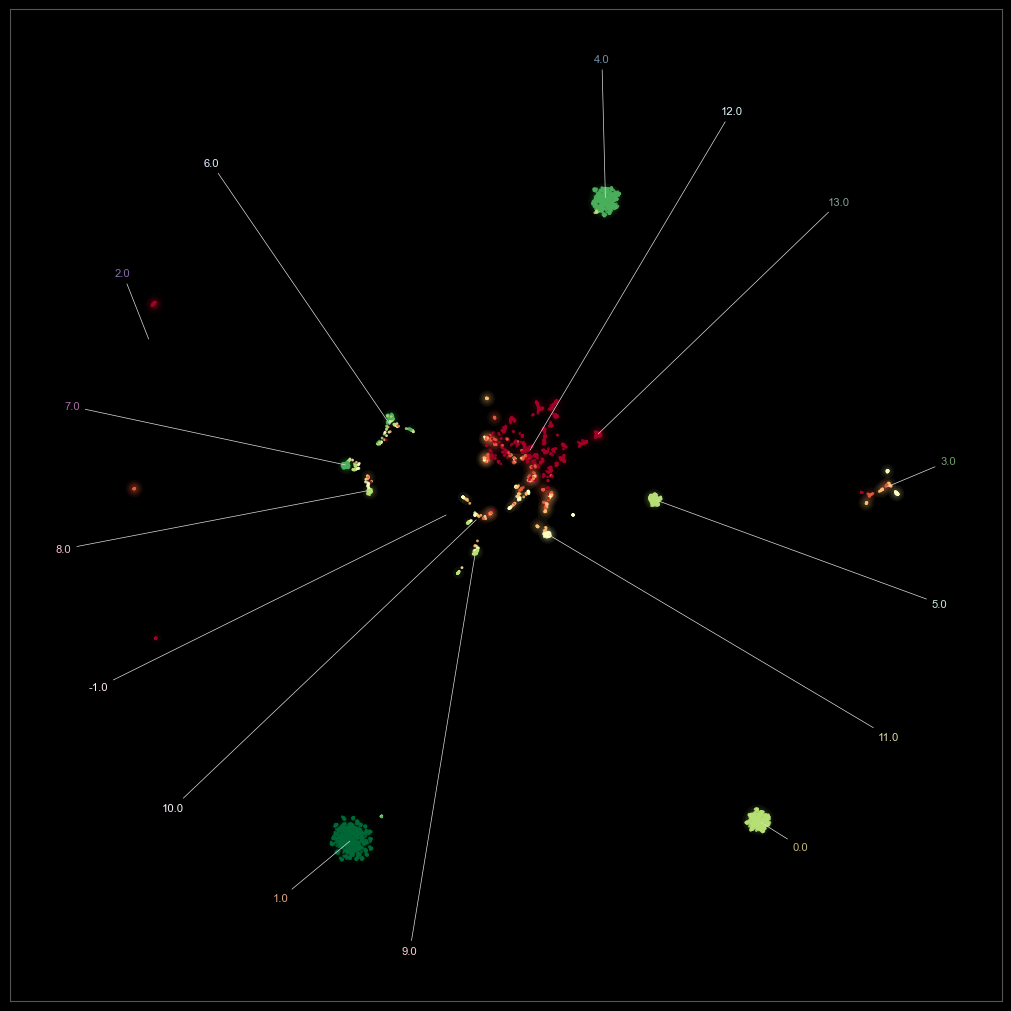

In [62]:
datamapplot.create_plot(data_map_coords = plot_df[['likert_umap_x', 'likert_umap_y']].values,
                        labels= plot_df['question_cluster_id'].astype(str).values,
                         marker_color_array=plot_df['colours'], noise_label=-1, font_family="Arial", darkmode=True)

In [61]:
cluster_heatmap_plot(dfq2, x="question_cluster_id", y = likert_columns_with_prefix)

alt.VConcatChart(...)

With a cluster plot, the number in each box is % Positive. However, we need to differentiate between the rest being % negative and the rest being % neutral. This is the colour. The colour of the plot is based on % negative scores, with more % negative being dark red, and fewer being light green.

We can now see clusters of respondents in a much more nuanced ways...some people very negative (cluster 13). We see an issue around retirement, which may have got masked if we just looked at overall sentiment. Some people really like the city, but feel it's very unsuitable as a place for retirement. Similarly with raising children. It would be worth looking the the locations of these clusters, which parts of the city are they from?